# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Barges

<img src="Figures/system_layout_alternative_2.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib inline
%matplotlib notebook


import seaborn as sns
# sns.set(style="ticks")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_barge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# 
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000), 
             ('New-Panamax (12,500 TEU)', 12500), 
             ('ULCS (21,000 TEU)', 21000)],
    value=12500, 
    description='OGV:')

barge = widgets.Dropdown(
    options=[('Small (200 TEU)', 200), 
             ('Medium (250 TEU)', 250), 
             ('Large (300 TEU)', 300)],
    value=250, 
    description='Barge:')

life_cycle = widgets.IntSlider(
    value=10, min=5, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('\033[1m*** Input Values \033[0m')
display(annual_demand, offshore_onshore_distance, container_ship, barge, life_cycle)

*** Input Values 


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

IntSlider(value=10, description='Life cycle:', max=30, min=5, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

(0, 1575000.0)

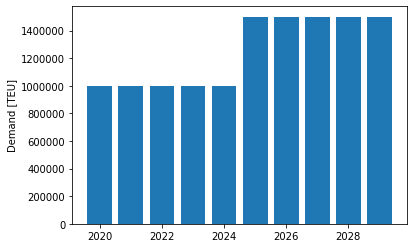

In [4]:
containers = demand  # TEU
years = list(range(startyear, startyear+lifecycle))
demand = []

for year in years:
    if year < 2025:
        demand.append(containers)
    elif year < 2030:
        demand.append(containers * 1.5)
    else:
        demand.append(containers * 2.0)

plt.bar(years, demand,color='tab:blue')
# plt.step(years, demand, where='mid', color='tab:orange')
plt.ylabel('Demand [TEU]')
plt.ylim(0,)

In [5]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand}

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container.scenario_data)

# combine
demand = [container]

{'name': 'Laden', 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0}


## 0.2 Generate vessels

In [6]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [7]:
OffshoreBarge = container_system_offshore_barge.System(
                startyear = startyear,
                lifecycle = lifecycle,
                stack_equipment = 'rs',
                laden_stack = 'rs',
                elements = demand + vessels,
                crane_type_defaults = container_defaults.sts_crane_data,
                offshore_distance = offshore_distance,
                barge_type = 'medium',
                bathymetry_factor = 0.85,
                allowable_berth_occupancy = 0.50,
                transhipment_ratio = 0.0,
                debug = True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, revenues)
    7. calculate PV's and aggregate to NPV

In [8]:
OffshoreBarge.simulate()


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000.0
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

quay_length_in_func 430 m
quay_depth 17 m
  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insuran

df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    2000000.0         0.0
2  2022          0.0    200000.0
3  2023          0.0    200000.0
4  2024          0.0    200000.0
barges_online 3
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    3000000.0         0.0
2  2022          0.0    300000.0
3  2023          0.0    300000.0
4  2024          0.0    300000.0
barges_online 4
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    4000000.0         0.0
2  2022          0.0    400000.0
3  2023          0.0    400000.0
4  2024          0.0    400000.0
barges_online 5
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    5000000.0         0.0
2  2022          0.0    500000.0
3  2023          0.0    500000.0
4  2024          0.0    500000.0
barges_online 6
  *** add Barge to elements
df    Year  Barge Ca

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2136: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2212: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    7000000.0         0.0
2  2022          0.0    700000.0
3  2023          0.0    700000.0
4  2024          0.0    700000.0
barges_online 8
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    8000000.0         0.0
2  2022          0.0    800000.0
3  2023          0.0    800000.0
4  2024          0.0    800000.0
barges_online 9
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021    9000000.0         0.0
2  2022          0.0    900000.0
3  2023          0.0    900000.0
4  2024          0.0    900000.0
barges_online 10
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021   10000000.0         0.0
2  2022          0.0   1000000.0
3  2023          0.0   1000000.0
4  2024          0.0   1000000.0
barges_online 11
  *** add Barge to elements
df    Year  Barge Ca

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2632: FutureWarning:

`item` has been deprecated and will be removed in a future version




df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280

df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.0
  *** add Empty Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.0
  *** add Empty Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.0
  *** add Empty Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.

df    Year  Terminal Capex  Maintenance
0  2020      18000000.0          0.0
1  2021      12000000.0          0.0
2  2022             0.0        600.0
3  2023             0.0        600.0
4  2024             0.0        600.0
     Onshore barge berth capacity planned (@ start of year): 0 TEU/yr
     Onshore Barge berth capacity online (@ start of year): 0 TEU/yr
     Onshore Barge berth service rate planned (@ start of year): inf
     Onshore Barge berth capacity required (@ start of year): 0 TEU/yr

  *** add Onshore Barge Berth to elements
df    Year  Terminal Capex  Maintenance
0  2020      18000000.0          0.0
1  2021      12000000.0          0.0
2  2022             0.0        600.0
3  2023             0.0        600.0
4  2024             0.0        600.0
  *** add Onshore Barge Berth to elements
df    Year  Terminal Capex  Maintenance
0  2020      18000000.0          0.0
1  2021      12000000.0          0.0
2  2022             0.0        600.0
3  2023             0.0        600.

4  2024             0.0      10000.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  144230.769231
3  2023             0.0      10000.0  144230.769231
4  2024             0.0      10000.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  144230.769231
3  2023             0.0      10000.0  144230.769231
4  2024             0.0      10000.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  144230.769231
3  2023          

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  144230.769231
3  2023             0.0      10000.0  144230.769231
4  2024             0.0      10000.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  144230.769231
3  2023             0.0      10000.0  144230.769231
4  2024             0.0      10000.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  144230.769231
3  2023             0.0      10000.0  144230.769231
4  2024             0.0      10000.0  144230.76

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  144230.769231
3  2023             0.0       8500.0  144230.769231
4  2024             0.0       8500.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  144230.769231
3  2023             0.0       8500.0  144230.769231
4  2024             0.0       8500.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  144230.769231
3  2023             0.0       8500.0  144230.769231
4  2024             0.0       8500.0  144230.76

4  2024             0.0       8500.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  144230.769231
3  2023             0.0       8500.0  144230.769231
4  2024             0.0       8500.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  144230.769231
3  2023             0.0       8500.0  144230.769231
4  2024             0.0       8500.0  144230.769231
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  144230.769231
3  2023          

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
     Gate capacity planned     (@ start of year): 540
     Gate capacity online      (@ start of year): 540
     Gate service rate planned (@ start of year): 0.976
     Gate lane minutes         (@ start of year): 527

     Barge berth capacity planned (@ start of year): 1137248.8000000005 [TEU/yr]
     Barge berth capacity online (@ start of year): 1137248.8000000005 [TEU/yr]
     Barge berth service rate planned (@ start of year): 0.8793150628077159 [-]
     Barge berth capacity required (@ start of year): 1000000.0 [TEU/yr]

     Onshore barge berth capacity planned (@ start of year): 852936.6000000004 TEU/yr
     Onsho

4  2024             0.0          0.0        0.0     0.0
     Berth occupancy planned (after adding Crane): 0.548
     Berth occupancy online  (after adding Crane): 0.666

  *** add STS crane to elements
df    Year  Terminal Capex  Maintenance  Insurance  Labour
0  2020             0.0          0.0        0.0     0.0
1  2021             0.0          0.0        0.0     0.0
2  2022             0.0          0.0        0.0     0.0
3  2023             0.0          0.0        0.0     0.0
4  2024             0.0          0.0        0.0     0.0
     Berth occupancy planned (after adding Crane): 0.52
     Berth occupancy online  (after adding Crane): 0.666

  *** add STS crane to elements
df    Year  Terminal Capex  Maintenance  Insurance  Labour
0  2020             0.0          0.0        0.0     0.0
1  2021             0.0          0.0        0.0     0.0
2  2022             0.0          0.0        0.0     0.0
3  2023             0.0          0.0        0.0     0.0
4  2024             0.0      

df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021             0.0          0.0
2  2022             0.0          0.0
3  2023             0.0          0.0
4  2024             0.0          0.0
  *** add OOG stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021             0.0          0.0
2  2022             0.0          0.0
3  2023             0.0          0.0
4  2024             0.0          0.0
     Number of stack Equipment online (@ start of year): 40

     Gate capacity planned     (@ start of year): 540
     Gate capacity online      (@ start of year): 540
     Gate service rate planned (@ start of year): 1.464
     Gate lane minutes         (@ start of year): 791

  *** add Gate to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0     

df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.

df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
     Gate capacity planned     (@ start of year): 840
     Gate capacity online      (@ start of year): 8

df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020             0.0          0.0     0.0
1  2021             0.0          0.0     0.0
2  2022             0.0          0.0     0.0
3  2023             0.0          0.0     0.0
4  2024             0.0          0.0     0.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance  Labour
0  2020            

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:516: FutureWarning:

`item` has been deprecated and will be removed in a future version



## 3. Report all elements

In [9]:
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year     volume
0  2020  1000000.0
1  2021  1000000.0
2  2022  1000000.0
3  2023  1000000.0
4  2024  1000000.0
5  2025  1500000.0
6  2026  1500000.0
7  2027  1500000.0
8  2028  1500000.0
9  2029  1500000.0, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '3dcd6bae-1b5d-11ea-869f-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'name': 'Fully_Cellular_1', 'id': '3dcea35c-1b5d-11ea-91a4-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'd

9  2029             0.0      10000.0  144230.769231  1066.94}

Empty Handler

{'triggers': [], 'labour': 144230.76923076922, 'maintenance': 10000.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'offshore_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'off_terminal_capex': 505000, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'empty_handler', 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 15, 'unit_rate': 500000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'crew': 1, 'salary': 35000, 'fuel_consumption': 1.5, 'required': 5, 'year_purchase': [], 'year_online': 2022, 'name': 'Empty Handler', 'id': '3e5236b4-1b5d-11ea-b08f-04d3b0b539c4', 'shift': 5.769230769230769, 'df':    Year


Reach stacker

{'triggers': [], 'labour': 250000, 'maintenance': 50000.0, 'energy': [], 'insurance': 0, 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'offshore_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'off_terminal_capex': 505000, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'rs', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 500000, 'mobilisation': 5000, 'maintenance_perc': 0.1, 'insurance_perc': 0, 'crew': 2, 'salary': 50000, 'required': 4, 'fuel_consumption': 1, 'power_consumption': 0, 'year_purchase': [], 'year_online': 2022, 'name': 'Reach stacker', 'id': '3ec76f69-1b5d-11ea-9169-04d3b0b539c4', 'shift': 10, 'df':    Year  Terminal Capex  Maintenance    Labour        Fuel
0  2020


Barge_Berth

{'land_use': [], 'triggers': [], 'labour': [], 'maintenance': 600.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'offshore_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'off_terminal_capex': 30000000, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'barge_berth', 'ownership': 'Terminal operator', 'delivery_time': 2, 'lifespan': 50, 'unit_rate': 30000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'nom_crane_productivity': 15.0, 'utilisation': 0.9, 'efficiency': 0.75, 'crane_per_berth': 1.3, 'handling_time_ratio': 0.9, 'peak_factor': 1.1, 'year_purchase': [], 'year_online': 2027, 'name': 'Barge_Berth', 'id': '3f37e080-1b5d-11ea-93c7-04d3b0b539c4', 'df':    Year  Terminal Capex  Mai

In [10]:
# scroll_to_current_cell(preserve=True)

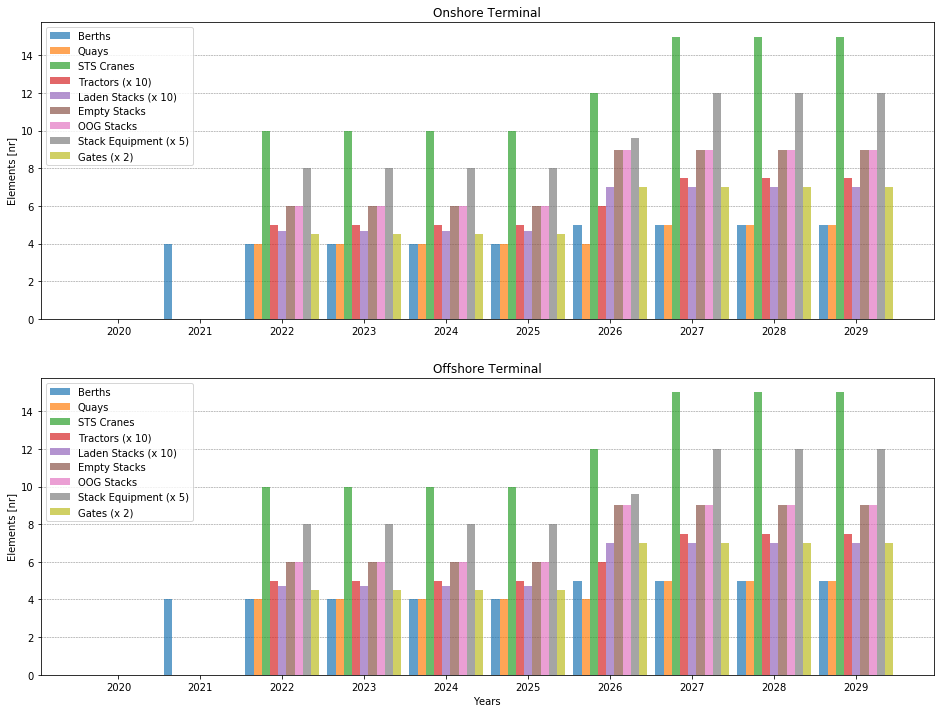

In [11]:
OffshoreBarge.terminal_elements_plot()

In [12]:
# OffshoreBarge.terminal_capacity_plot()

In [13]:
# OffshoreBarge.terminal_land_use_plot()

In [14]:
# OffshoreBarge.storage_area_plot()

#### Add cash flow information for each of the terminal elements.

In [15]:
island_construction, coastal_protection_construction, offshore_maintenance, off_terminal_capex, terminal_opex, capital_dredging, maintenance_dredging, barge_capex, barge_opex, cash_flows, cash_flows_df, cash_flows_WACC_real_df, NPV = OffshoreBarge.net_present_value()

In [16]:
# OffshoreBarge.terminal_opex_plot(cash_flows_df)

In [17]:
# OffshoreBarge.total_opex_plot(cash_flows_df)

In [18]:
# print('\033[1mCash Flow Plot\033[0m')
# OffshoreBarge.cashflow_plot(cash_flows_df)

In [19]:
# scroll_to_current_cell(preserve=True)

In [20]:
print('\033[1m    Financial Indication\033[0m')
print('  * NPV: ${}'.format(f'{round(NPV,-6):,}'))

hide_columns_list = ['Maintenance', 'Insurance', 'Energy', 'Labour', 'Fuel', 'Demurrage']
cash_flows_WACC_real_df.style.hide_columns(hide_columns_list).hide_index()

    Financial Indication
  * NPV: $-2,930,000,000.0


Year,Island Construction,Coastal Protection Construction,Offshore Maintenance,Terminal Capex,Terminal Opex,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging,Total Cash Flow
2020,4.5e+06,2.73e+08,0,3.54968e+08,0,0,0,2.73792e+08,0,-9.0626e+08
2021,5.94354e+06,3.60575e+08,0,4.50976e+08,0,1.673e+08,0,2.41081e+08,0,-1.22587e+09
2022,0,0,3.19821e+06,0,4.68678e+07,0,1.47312e+07,0,1.5284e+07,-8.00812e+07
2023,0,0,2.8161e+06,0,4.12683e+07,0,1.29711e+07,0,1.34579e+07,-7.05135e+07
2024,0,0,2.47965e+06,0,3.63377e+07,0,1.14214e+07,0,1.185e+07,-6.20889e+07
2025,0,0,2.18339e+06,1.02892e+08,3.45258e+07,1.2968e+08,1.00568e+07,0,1.04343e+07,-2.89773e+08
2026,0,0,1.92253e+06,5.54674e+07,3.72154e+07,0,2.0274e+07,0,9.18762e+06,-1.24067e+08
2027,0,0,1.69284e+06,0,3.68348e+07,0,1.78517e+07,0,8.08993e+06,-6.44693e+07
2028,0,0,1.49059e+06,0,3.2434e+07,0,1.57189e+07,0,7.12338e+06,-5.67668e+07
2029,0,0,1.3125e+06,0,2.85589e+07,0,1.38409e+07,0,6.27231e+06,-4.99846e+07


 Cash Flow Plot - Weighted average cost of capital 


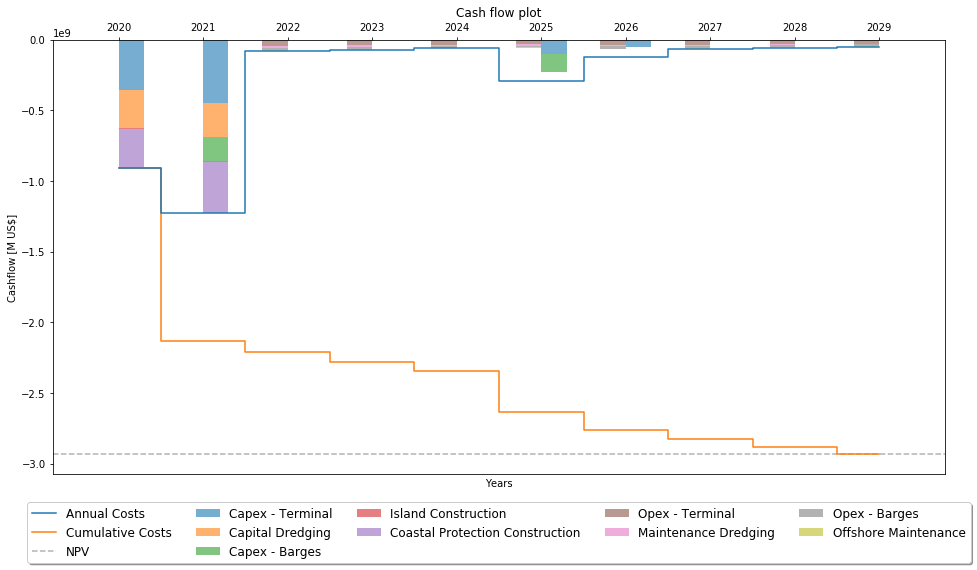

In [21]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
OffshoreBarge.cashflow_plot(cash_flows_WACC_real_df)

In [22]:
for year in range(startyear, startyear + lifecycle):
    total_land_use = OffshoreBarge.calculate_land_use(year)
    print(total_land_use)

0
0
406353.7500000002
406353.7500000002
406353.7500000002
406353.7500000002
543747.9000000004
573648.6500000004
573648.6500000004
573648.6500000004
